In [314]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [315]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [316]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [317]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [318]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [319]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [320]:
def Sampler(mu, Ntoys = int(1e5)):

    q0 = np.zeros(Ntoys)
  
    for i in tqdm(range(Ntoys)):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
    
    return q0

In [321]:
data = Data[4]
labels = list(data.keys())
#n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
n = s+b
N = n.shape[0]

In [322]:
# Con significancia
Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected = False)
Qobs

-21.04595409661052

In [323]:
q0 = Sampler(1.)

100%|███████████████████████████████████████████| 100000/100000 [00:25<00:00, 3971.70it/s]


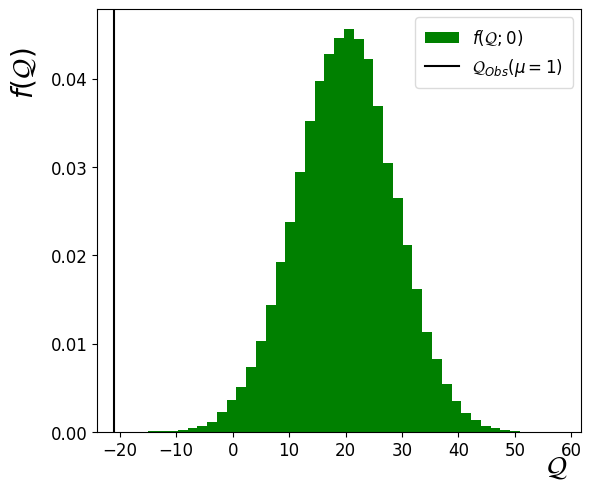

In [324]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=45,color='green',density=True,label=r'$f(\mathcal{Q};0)$')
plt.axvline(x=Qobs,color='k',label=r'$\mathcal{Q}_{Obs}(\mu=1)$')
#plt.yscale('log')

# Label X
ax.set_xlabel(r'$\mathcal{Q}$')
ax.xaxis.set_label_coords(0.95,-0.05)

# Label Y
ax.set_ylabel(r'$f(\mathcal{Q})$')
ax.yaxis.set_label_coords(-0.12,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
#plt.savefig('Significance_Q.pdf')

In [325]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [326]:
p0 = GetPValue(q0,Qobs,Null = True)
#p1 = GetPValue(q1,Qobs,Null = False)
print(p0)

0.0


In [327]:
Significancia = np.abs(norm.ppf(p0))
Significancia

inf

In [328]:
# Funcion en paralelo
def GetCls_for_mu(i, mu, Expected = False):

    Qobs = GetObsJointLnQ(GetLnQ,1,Expected)
    q0,q1 = Sampler(mu)
    
    p0 = GetPValue(q0, Qobs, Null = True)
    p1 = GetPValue(q1, Qobs, Null = False)

    Clb = 1 - p0
    Clsb = p1

    Cls = Clsb/Clb

    return i,Clsb

In [329]:
def GetCls_parallel(mu, Expected=False, num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = np.array([])

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):

            futures = np.append(futures,executor.submit(GetCls_for_mu, i, mu[i], Expected))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Clsb = future.result()
            p_value[i] = Clsb

    return p_value

In [330]:
# Estructura de datos para guardar
MatrizDatos = np.zeros((Mass.shape[0],3))
MatrizDatos[:,0] = Mass
MatrizDatos

array([[100.,   0.,   0.],
       [106.,   0.,   0.],
       [112.,   0.,   0.],
       [118.,   0.,   0.],
       [124.,   0.,   0.],
       [130.,   0.,   0.],
       [136.,   0.,   0.],
       [142.,   0.,   0.],
       [148.,   0.,   0.],
       [154.,   0.,   0.],
       [160.,   0.,   0.]])

In [ ]:
# Running the upper limits for each signal points

for i, data in enumerate(Data):

    print('--- Estimating Limits for ---', Mass[i])
    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
   # n = s+b # Para la significancia
    N = n.shape[0]

    Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected = False)    
    q0 = Sampler(1.)
    
    p0 = GetPValue(q0,Qobs,Null = True)
    Significance = np.abs(norm.ppf(p0))
    
   
    MatrizDatos[i,1] = p0
    MatrizDatos[i,2] = Significance

--- Estimating Limits for --- 100.0


 33%|██████████████▌                             | 32972/100000 [00:09<00:19, 3470.07it/s]

In [296]:
DataFinal = pd.DataFrame(MatrizDatos)
DataFinal.columns = ['Mass','p0','Significance']
DataFinal

,Mass,p0,Significance
0,100.0,0.68450,0.480320
1,106.0,0.69580,0.512359
2,112.0,0.47975,0.050781
3,118.0,0.00290,2.758879
4,124.0,0.00000,inf
5,130.0,0.00495,2.579303
6,136.0,0.44535,0.137419
7,142.0,0.69300,0.504372
8,148.0,0.25495,0.658993
9,154.0,0.15965,0.995897


In [297]:
DataFinal.to_csv('SignificanceMassScan.csv',index=False)

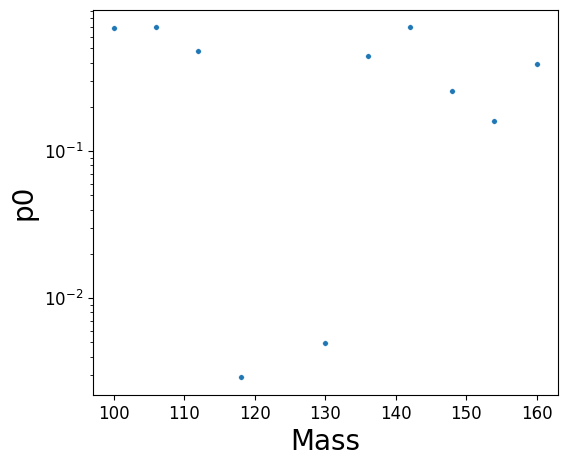

In [301]:
import seaborn as sns
sns.scatterplot(x='Mass',y='p0',data = DataFinal)
plt.yscale('log')